In [1]:
import numpy as np
import pandas as pd
import re, math
import matplotlib.pyplot as plt
from matplotlib import rcParams
from cycler import cycler

# configure pandas
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)

In [2]:
ret = pd.read_excel('/home/jk/data/online_retail_II.xlsx')
ret.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


## Check Data Types

In [3]:
ret.dtypes

Invoice                object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
Price                 float64
Customer ID           float64
Country                object
dtype: object

In [6]:
# ret['Customer ID'] = ret['Customer ID'].astype(int)
# ret.dtypes
## - Tried covnerting customer ID from float to int but null or inf values blocked it, will explore below
#___
# Number of item purchase instances by country
# each item purchased has its own row, so single transaction with multiple items is split across rows
# Most intem instances in UK
print('Number of Countries: ', ret['Country'].nunique())
ret['Country'].value_counts()

Number of Countries:  40


United Kingdom          485852
EIRE                      9670
Germany                   8129
France                    5772
Netherlands               2769
Spain                     1278
Switzerland               1187
Portugal                  1101
Belgium                   1054
Channel Islands            906
Sweden                     902
Italy                      731
Australia                  654
Cyprus                     554
Austria                    537
Greece                     517
United Arab Emirates       432
Denmark                    428
Norway                     369
Finland                    354
Unspecified                310
USA                        244
Japan                      224
Poland                     194
Malta                      172
Lithuania                  154
Singapore                  117
RSA                        111
Bahrain                    107
Canada                      77
Hong Kong                   76
Thailand                    76
Israel  

In [7]:
ret.shape

(525461, 8)

In [8]:
print('Number of Unique Customers: ', ret['Customer ID'].nunique())
# each item purchased has its own row, so single transaction with multiple items is split across rows
print('Total number of item puchase instances: ', ret.shape[0])

Number of Unique Customers:  4383
Total number of item puchase instances:  525461


In [9]:
# Table of data types and number of null values for each column
tab_info=pd.DataFrame(ret.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(ret.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(ret.isnull().sum()/ret.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

/tmp/ipykernel_1037/818548229.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(ret.isnull().sum()).T.rename(index={0:'null values (nb)'}))
/tmp/ipykernel_1037/818548229.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(ret.isnull().sum()/ret.shape[0]*100).T.


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,2928,0,0,0,107927,0
null values (%),0.0,0.0,0.557225,0.0,0.0,0.0,20.539488,0.0


## Remove Rows missing Customer ID
- 20% of transactions aren't assigned to a customer
- Since we are building a customer segmentation, we will drop those rows
- This still leaves us with plenty of instances

In [10]:
ret.dropna(axis = 0, subset = ['Customer ID'], inplace = True)
print('Dataframe dimensions:', ret.shape)

Dataframe dimensions: (417534, 8)


## Verify No null values remaining

In [11]:
# Table of data types and number of null values for each column
tab_info=pd.DataFrame(ret.dtypes).T.rename(index={0:'column type'})
tab_info=tab_info.append(pd.DataFrame(ret.isnull().sum()).T.rename(index={0:'null values (nb)'}))
tab_info=tab_info.append(pd.DataFrame(ret.isnull().sum()/ret.shape[0]*100).T.
                         rename(index={0:'null values (%)'}))
display(tab_info)

/tmp/ipykernel_1037/818548229.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(ret.isnull().sum()).T.rename(index={0:'null values (nb)'}))
/tmp/ipykernel_1037/818548229.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tab_info=tab_info.append(pd.DataFrame(ret.isnull().sum()/ret.shape[0]*100).T.


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
column type,object,object,object,int64,datetime64[ns],float64,float64,object
null values (nb),0,0,0,0,0,0,0,0
null values (%),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
pd.DataFrame([{'products': len(ret['StockCode'].value_counts()),    
               'transactions': len(ret['Invoice'].value_counts()),
               'customers': len(ret['Customer ID'].value_counts()),  
              }], columns = ['products', 'transactions', 'customers'], index = ['quantity'])

,products,transactions,customers
quantity,4031,23587,4383


### Convert Customer ID from float to int

In [13]:
ret['Customer ID'] = ret['Customer ID'].astype(int)

## Create baskets dataframe with one row for each transaction

In [14]:
temp = ret.groupby(by=['Customer ID', 'Invoice'], as_index=False)['InvoiceDate'].count()
nproducts_basket = temp.rename(columns = {'InvoiceDate':'Number of Products'})
nproducts_basket.sort_values('Customer ID').head(10)

,Customer ID,Invoice,Number of Products
0,12346,491725,1
14,12346,C525274,1
13,12346,C525099,1
12,12346,C514024,10
11,12346,C495800,1
9,12346,499763,5
8,12346,495295,1
10,12346,513774,19
6,12346,493412,1
5,12346,493410,1


In [15]:
print('Descriptive Stats for Number of Products in each basket')
nproducts_basket['Number of Products'].describe()

Descriptive Stats for Number of Products in each basket


count    23587.000000
mean        17.701870
std         21.330514
min          1.000000
25%          3.000000
50%         11.000000
75%         24.000000
max        270.000000
Name: Number of Products, dtype: float64

- If C appears at the beginning of Invoice the order was canceled
- Descriptives show that some people only purchase a single items, while others buy upwards of 270 in one basket

### Check number of Canceled Orders

In [17]:
nproducts_basket['order_canceled'] = nproducts_basket['Invoice'].str.contains('C', na=False).astype(int)
#____
n1 = nproducts_basket['order_canceled'].sum()
n2 = nproducts_basket.shape[0]
print('Number of orders canceled: {}/{} ({:.2f}%) '.format(n1, n2, n1/n2*100))

Number of orders canceled: 4372/23587 (18.54%) 


- 18.5% of orders canceled, a sizeable amount

In [18]:
ret.sort_values('Customer ID').head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
253040,513774,48185,DOORMAT FAIRY CAKE,1,2010-06-28 13:53:00,7.49,12346,United Kingdom
107804,499763,15056P,EDWARDIAN PARASOL PINK,1,2010-03-02 13:08:00,5.95,12346,United Kingdom
253046,513774,21955,DOORMAT UNION JACK GUNS AND ROSES,1,2010-06-28 13:53:00,7.49,12346,United Kingdom
253045,513774,20685,DOORMAT RED SPOT,1,2010-06-28 13:53:00,7.49,12346,United Kingdom
45228,493410,TEST001,This is a test product.,5,2010-01-04 09:24:00,4.50,12346,United Kingdom


## Check if all canceled orders correspond to an order that was made previously

In [21]:
check = ret[ret['Quantity'] < 0][['Customer ID','Quantity', 'StockCode','Description','Price']]
for index, col in  check.iterrows():
    if ret[(ret['Customer ID'] == col[0]) & (ret['Quantity'] == -col[1]) 
                & (ret['Description'] == col[2])].shape[0] == 0: 
        print(ret.loc[index])
        print(15*'-'+'>'+' HYPOTHESIS DOES NOT HOLD')
        break

Invoice                         C489449
StockCode                         22087
Description    PAPER BUNTING WHITE LACE
Quantity                            -12
InvoiceDate         2009-12-01 10:33:00
Price                              2.95
Customer ID                       16321
Country                       Australia
Name: 178, dtype: object
---------------> HYPOTHESIS DOES NOT HOLD


In [22]:
ret_cleaned = ret.copy(deep = True)
ret_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtful_entry = []

for index, col in  ret.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = ret[(ret['Customer ID'] == col['Customer ID']) &
                         (ret['StockCode']  == col['StockCode']) & 
                         (ret['InvoiceDate'] < col['InvoiceDate']) & 
                         (ret['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtful_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        ret_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            ret_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break            

Above I checked the two cases, whether:

    1. a cancel order exists without counterpart
    2. there's at least one counterpart with the exact same quantity

The index of the corresponding cancel order are respectively kept in the doubtful_entry and entry_to_remove lists whose sizes are:


In [27]:
print("doubtful_entry: {}".format(len(doubtful_entry)))
print("entry_to_remove: {}".format(len(entry_to_remove)))

doubtful_entry: 1617
entry_to_remove: 8069


In [28]:
print('Percent of entry_to_remove: {}'.format(len(entry_to_remove)/ret.shape[0]*100))
print('Percent of doubtful_entry: {}'.format(len(doubtful_entry)/ret.shape[0]*100))

Percent of entry_to_remove: 1.9325372305009894
Percent of doubtful_entry: 0.38727385075227405


- With these canceled orders consisting of ~2% and .4% of the total data, seems best to delete them

In [38]:
ret_cleaned.drop(entry_to_remove, axis = 0, inplace = True)
ret_cleaned.drop(doubtful_entry, axis = 0, inplace = True)
remaining_entries = ret_cleaned[(ret_cleaned['Quantity'] < 0) & (ret_cleaned['StockCode'] != 'D')]
print("number of remaining canceled orders: {}".format(remaining_entries.shape[0]))

number of remaining canceled orders: 61


- after removing those, there are 61 remaining canceled orders

In [30]:
remaining_entries.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,QuantityCanceled
9324,C490133,21314,SMALL GLASS HEART TRINKET POT,-504,2009-12-03 18:36:00,1.85,17949,United Kingdom,0
26929,C491676,21868,POTTING SHED TEA MUG,-12,2009-12-13 12:09:00,1.25,14685,United Kingdom,0
28066,C491728,22139,RETRO SPOT TEA SET CERAMIC 11 PC,-4,2009-12-14 09:18:00,4.95,12471,Germany,0
46326,C493689,79000,MOROCCAN TEA GLASS,-18,2010-01-05 12:45:00,0.85,14606,United Kingdom,0
47742,C493836,84050,PINK HEART SHAPE EGG FRYING PAN,-24,2010-01-07 13:49:00,1.65,12839,United Kingdom,0


In [37]:
ret_cleaned[(ret_cleaned['Customer ID'] == 12471) & (ret_cleaned['StockCode'] == '22139')]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,QuantityCanceled


- these canceled order dont appear in the ret_cleaned df

In [39]:
list_special_codes = ret_cleaned[ret_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex=True, na=False)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'TEST001', 'TEST002',
       'PADS', 'ADJUST', 'ADJUST2', 'SP1002'], dtype=object)

In [40]:
ret_cleaned['StockCode'].value_counts().head()

85123A    3153
85099B    1743
22423     1708
21212     1586
21232     1407
Name: StockCode, dtype: int64

### Create Total Price Column
- subtracting out quantities canceled

In [41]:
ret_cleaned['TotalPrice'] = ret_cleaned['Price'] * (ret_cleaned['Quantity'] - ret_cleaned['QuantityCanceled'])
ret_cleaned.sort_values('Customer ID').head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,QuantityCanceled,TotalPrice
107800,499763,20682,RED SPOTTY CHILDS UMBRELLA,1,2010-03-02 13:08:00,3.25,12346,United Kingdom,0,3.25
253035,513774,22690,DOORMAT HOME SWEET HOME BLUE,1,2010-06-28 13:53:00,7.49,12346,United Kingdom,0,7.49
107801,499763,20679,EDWARDIAN PARASOL RED,1,2010-03-02 13:08:00,5.95,12346,United Kingdom,0,5.95
27994,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.50,12346,United Kingdom,0,45.00
370048,C525099,D,Discount,-1,2010-10-04 09:54:00,1.00,12346,United Kingdom,0,-1.00


### Combine Individual Items from same order together to create a total Basket Price

In [42]:
#
temp = ret_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['TotalPrice'].sum()
basket = temp.rename(columns = {'TotalPrice':'BasketPrice'})
#
ret_cleaned['InvoiceDate_int'] = ret_cleaned['InvoiceDate'].astype('int64')
temp = ret_cleaned.groupby(by=['Customer ID', 'Invoice'], as_index=False)['InvoiceDate_int'].mean()
ret_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
basket.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#
basket = basket[basket['BasketPrice'] > 0]
basket.sort_values('Customer ID').head()

,Customer ID,Invoice,BasketPrice,InvoiceDate
0,12346,491725,45.0,2009-12-14 08:34:00
1,12346,491742,22.5,2009-12-14 11:00:00
2,12346,491744,22.5,2009-12-14 11:02:00
3,12346,492718,22.5,2009-12-18 10:47:00
4,12346,492722,1.0,2009-12-18 10:55:00


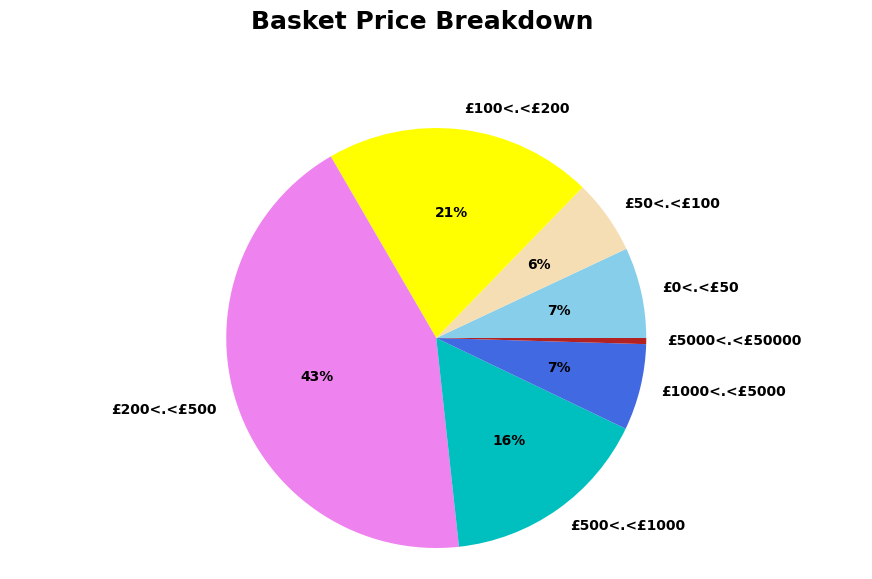

In [46]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket[(basket['BasketPrice'] < price) &
                       (basket['BasketPrice'] > price_range[i-1])]['BasketPrice'].count()
    count_price.append(val)
# Construct Pie Chart        
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['skyblue', 'wheat', 'yellow', 'violet', 'c', 'royalblue','firebrick']
labels = [ '£{}<.<£{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes  = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]
ax.pie(sizes, explode = explode, labels=labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle=0)
ax.axis('equal')
f.text(0.5, 1.01, "Basket Price Breakdown", ha='center', fontsize = 18);

- Most purchases are quite large with ~65% of basket prices exceeding 200 pounds

In [48]:
# save dataframes as csv
ret.to_csv('/home/jk/repos/predictive-segmentation/data/online_retail_II_wrangled.csv', index=False)
ret_cleaned.to_csv('/home/jk/repos/predictive-segmentation/data/online_retail_II_w-cleaned.csv', index=False)
basket.to_csv('/home/jk/repos/predictive-segmentation/data/online_retail_II_baskets.csv', index=False)